# Фитнес-центр: стратегия взаимодействия с клиентами на основе аналитических данных

## Описание проекта

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.<br>
Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет, чтобы разработать стратегию взаимодействия с клиентами на основе аналитических данных, <br>
Задача проекта — провести анализ и подготовить план действий по удержанию клиентов.<br>

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- Данные клиента за предыдущий до проверки факта оттока месяц:
    - `'gender'` — пол;
    - `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
    - `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - `'Phone'` — наличие контактного телефона;
    - `'Age'` — возраст;
    - `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
    - `'Group_visits'` — факт посещения групповых занятий;
    - `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
    - `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `'Churn'` — факт оттока в текущем месяце.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv')

except FileNotFoundError:
    data = pd.read_csv('gym_churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.columns = data.columns.str.lower()
data.sample(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3265,1,1,1,1,1,1,1,25,162.041680,1.0,7,2.633648,2.561936,0
1215,0,0,0,1,1,1,0,27,210.881022,1.0,2,1.350154,0.558745,1
2572,1,1,0,1,0,1,1,32,88.808947,1.0,15,2.967029,3.066052,0
481,0,1,0,0,1,12,0,27,153.684604,9.0,6,2.247282,2.251551,0
2459,1,1,1,0,1,6,0,31,104.604198,4.0,1,3.008668,3.015798,0


In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Поменяю местами столбцы:<br>
слева - Данные клиента,<br>
справа - Информация на основе журнала посещения

In [7]:
data.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [8]:
data = data[['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'age',
 'lifetime',
 'contract_period',
 'month_to_end_contract',
 'group_visits',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'avg_additional_charges_total',
 'churn']]

Данные чистые, готовы к следующему этапу проекта.

## Исследовательский анализ данных (EDA)

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
churn_group = data.groupby('churn').mean().T.reset_index().round(4)
churn_group.columns = ['feature','no_churn', 'churn']
churn_group

,feature,no_churn,churn
0,gender,0.5100,0.5108
1,near_location,0.8731,0.7681
2,partner,0.5342,0.3553
3,promo_friends,0.3535,0.1838
4,phone,0.9037,0.9029
5,age,29.9765,26.9896
6,lifetime,4.7118,0.9906
7,contract_period,5.7472,1.7286
8,month_to_end_contract,5.2831,1.6626
9,group_visits,0.4641,0.2686


По таблице средних значений сделаю предварительное обобщение по группам no_churn и churn:
1. По гендерному признаку группы схожи.
2. По возрасту группа no_churn старше на три года группы churn.
3. Группа no_churn тратит больше денег на дополнительные услуги.

Все остальные признаки также отличаются, но их я расмотрю подробно после проведения исследования. 

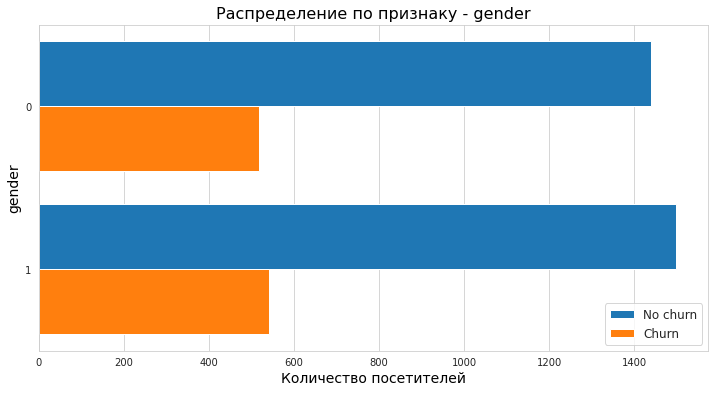

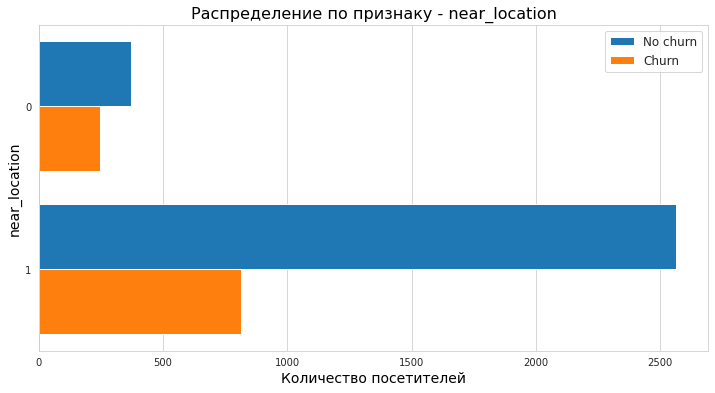

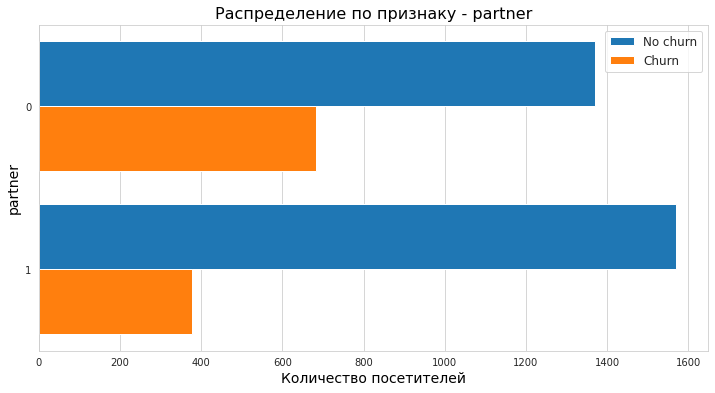

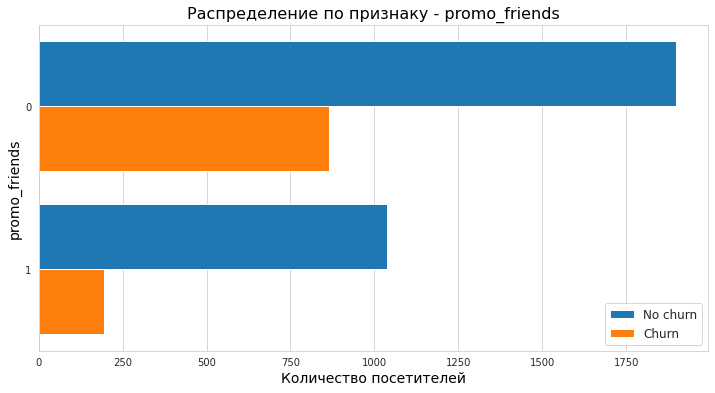

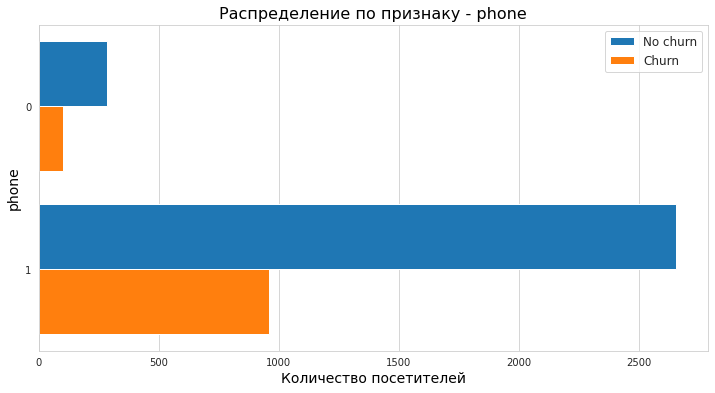

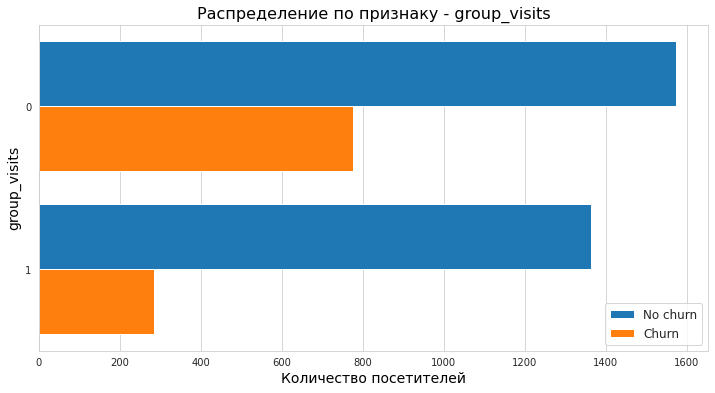

In [11]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(12, 6))
    sns.set_style(style="whitegrid")
    ax = sns.countplot(data=data, y = data[column], hue='churn', saturation=1)
    ax.set_title('Распределение по признаку - '  +column, fontsize = 16, color = 'black')
    plt.ylabel(column, fontsize = 14, color = 'black')
    plt.xlabel('Количество посетителей', fontsize = 14, color = 'black')
    ax.legend(['No churn', 'Churn'], loc='best', fontsize = 12)
plt.show()

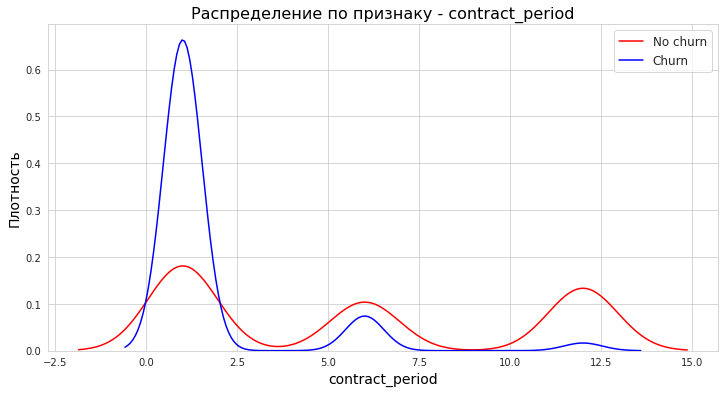

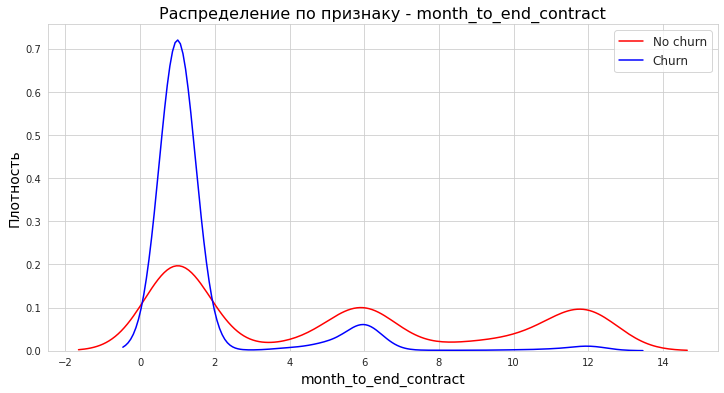

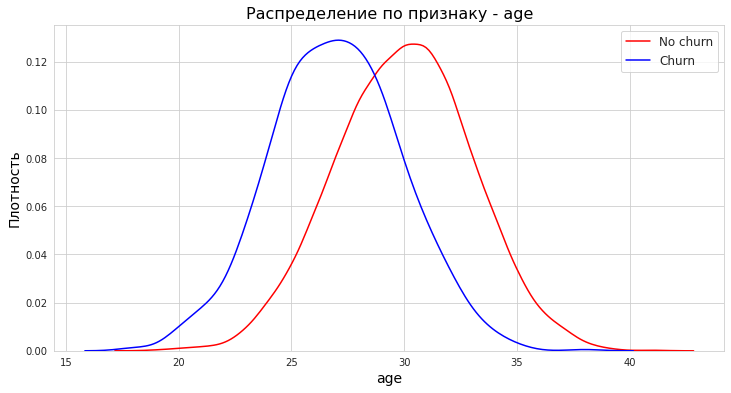

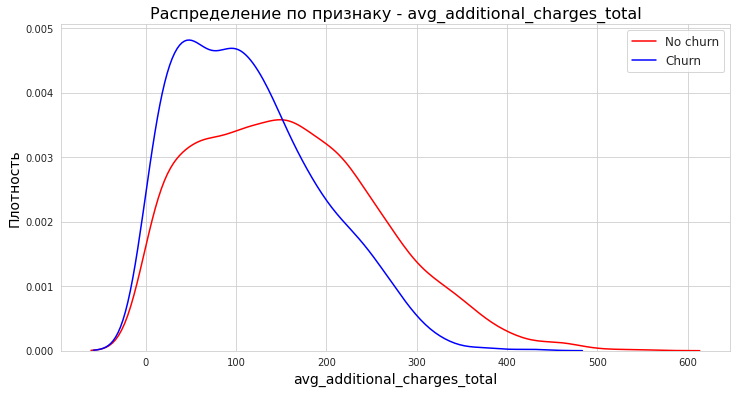

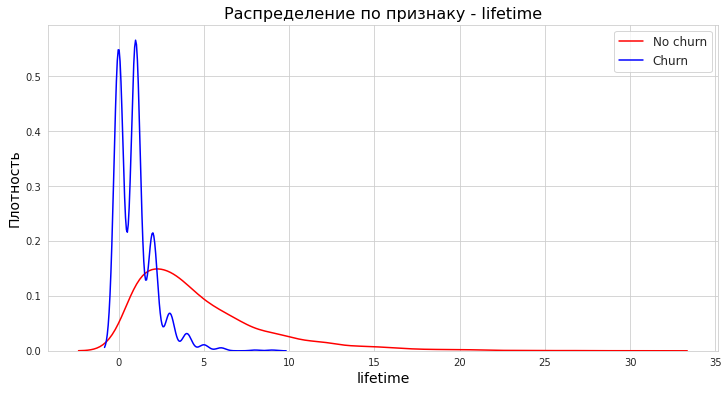

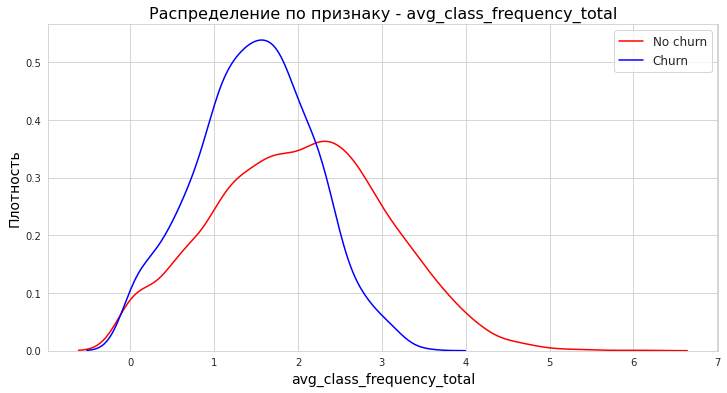

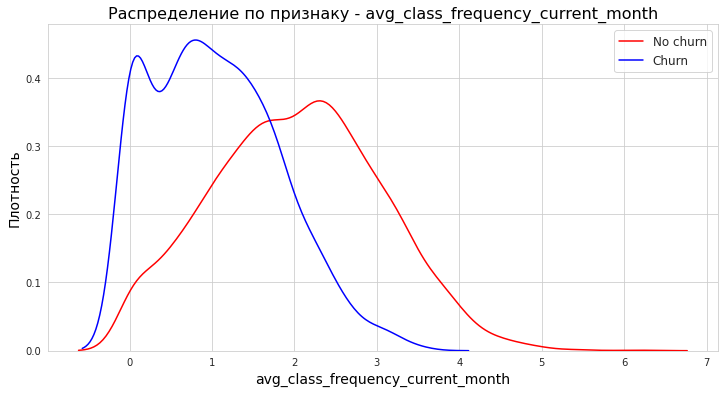

In [12]:
for column in ['contract_period', 'month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
        plt.figure(figsize = (12,6))
        sns.kdeplot(data.loc[data['churn']==0, column], color = 'r')
        sns.kdeplot(data.loc[data['churn']==1, column], color = 'b')
        plt.title('Распределение по признаку - ' +column, fontsize = 16, color = 'black')
        plt.xlabel(column, fontsize = 14, color = 'black')
        plt.ylabel('Плотность', fontsize = 14, color = 'black')
        plt.legend(['No churn', 'Churn'], loc='best', fontsize = 12)
plt.show()

In [13]:
cm = data.corr()

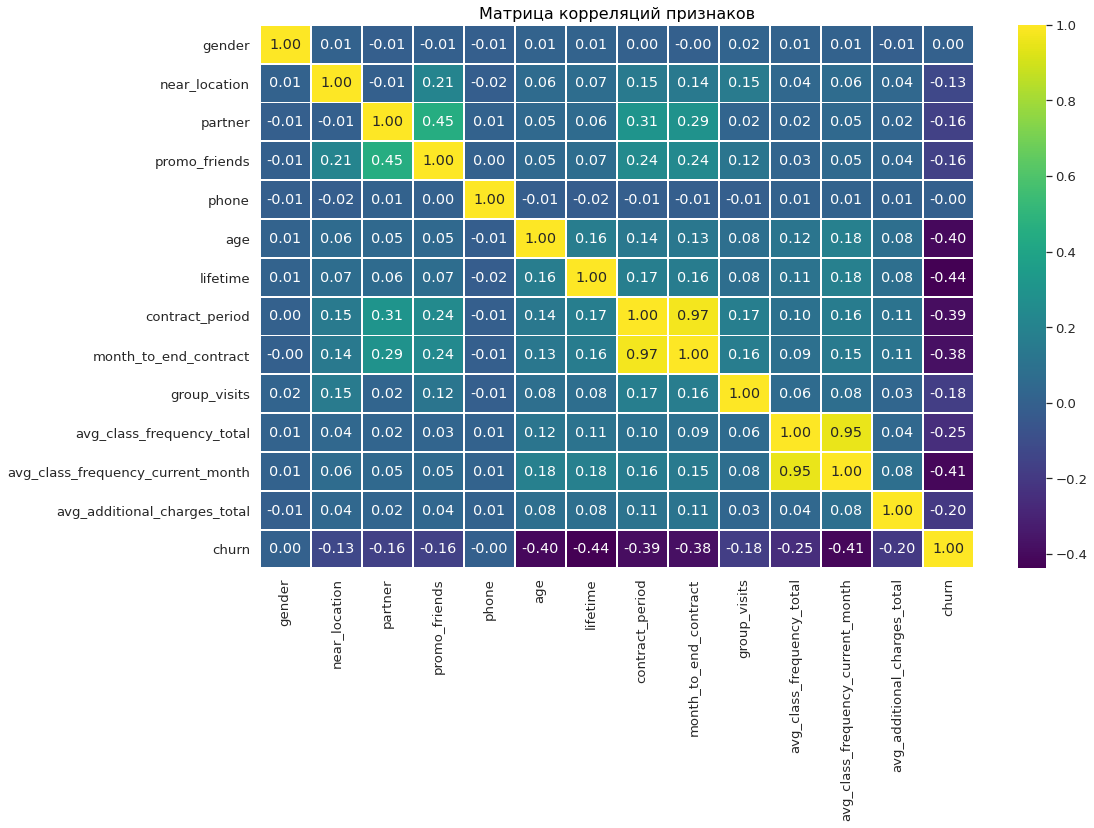

In [14]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.9, cmap='viridis')
plt.title('Матрица корреляций признаков',  fontsize = 16, color = 'black')
plt.show()

### Заключение:

1. Мультиколлинеарность обнаруживают пары:<br>
   'contract_period' - 'month_to_end_contract'. Корреляция - 0.97<br>
   'avg_class_frequency_total' - 'avg_class_frequency_current_month'. Корреляция - 0.95<br>
2. Отсутствие корреляции с целевым показателем демонстрируют: 'gender' и 'phone'.<br>
3. Избавлюсь от мультиколлинеарности, удалив по одному признаку из каждой пары: 'month_to_end_contract' и 'avg_class_frequency_total'<br>
4. Удалю признаки не влияющие на целевой показатель: 'gender' и 'phone'

In [15]:
dt_eda = data.drop(['gender', 'phone', 'month_to_end_contract', 'avg_class_frequency_total'], axis=1)

## Модель прогнозирования оттока клиентов

### Разбивка данных на обучающую и валидационную выборку функцией train_test_split()

In [16]:
X = dt_eda.drop('churn', axis=1)
y = dt_eda['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

### Обучение модели на train-выборке - LogisticRegression и RandomForestClassifier.

In [17]:
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

In [18]:
def estimate_metrics(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))

### Оценка метрики accuracy, precision и recall:

In [19]:
for i in models:
    print(i)
    estimate_metrics(i, X_train, y_train, X_test, y_test)
    type(models)

LogisticRegression(random_state=0)
Accuracy: 0.88 Precision: 0.75 Recall: 0.76
RandomForestClassifier(random_state=0)
Accuracy: 0.90 Precision: 0.81 Recall: 0.77


### Вывод:

Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам.<br>
Precision измеряет точность модели при определении класса Positive.<br>
Recall измеряет способность модели обнаруживать выборки, относящиеся к классу Positive.<br>
По всем трём показателям модель RandomForestClassifier показал себя лучше, чем LogisticRegression.

## Кластеризация клиентов

### Матрица расстояний и дендрограмма:

In [20]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

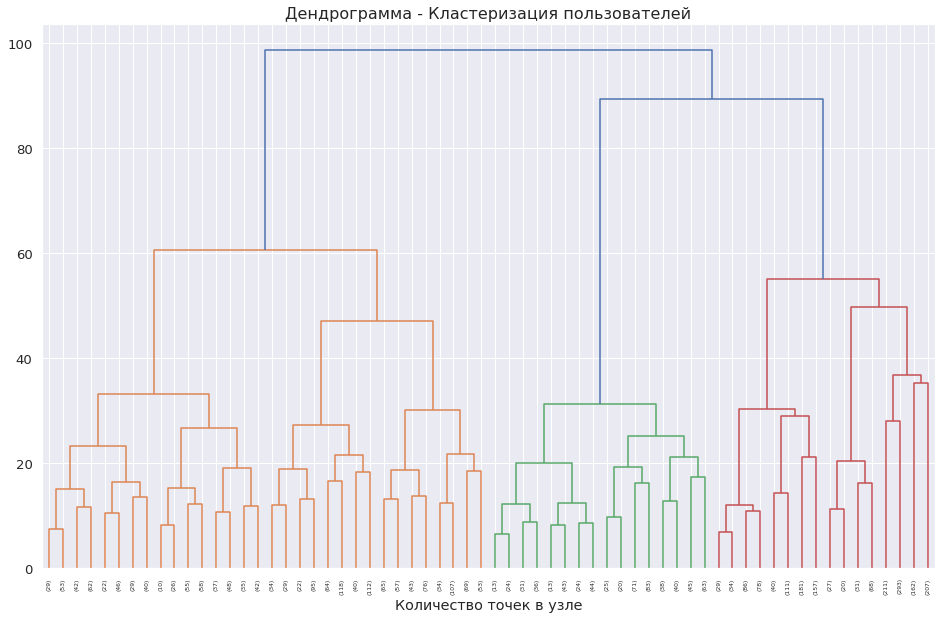

In [21]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(16, 10))
dendrogram(linked, truncate_mode="level", p=5)
plt.title('Дендрограмма - Кластеризация пользователей', fontsize=16)
plt.xlabel("Количество точек в узле")
plt.show()

Исходя из дендрограммы можно выделить 3 кластера пользователей.

### Модель кластеризации на основании алгоритма K-Means:

У меня получилось три кластера, но по условию инструкции к проекту:<br> 
Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов.

In [22]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)
dt_eda['cluster'] = labels

In [23]:
counts = dt_eda['cluster'].value_counts()
percent = counts / counts.sum()
fmt = '{:.1%}'.format
pd.DataFrame({'counts': counts, 'percent': percent.map(fmt)})

,counts,percent
2,1018,25.4%
3,990,24.8%
1,712,17.8%
4,674,16.9%
0,606,15.2%


In [24]:
dt_eda.groupby(['cluster']).mean().round(2).T

cluster,0,1,2,3,4
near_location,0.00,1.00,1.00,1.00,0.99
partner,0.49,0.15,0.95,0.20,0.57
promo_friends,0.07,0.10,1.00,0.07,0.05
age,28.69,29.16,29.51,28.23,30.56
lifetime,2.91,2.77,4.03,2.34,7.04
contract_period,2.94,2.81,7.14,2.02,8.41
group_visits,0.23,1.00,0.51,0.00,0.41
avg_class_frequency_current_month,1.60,1.68,1.88,1.43,2.33
avg_additional_charges_total,136.98,140.53,151.99,134.39,173.48
churn,0.40,0.27,0.13,0.48,0.01


Изучив таблицу могу сделать вывод, что алгоритм K-Means не самый лучший метод кластеризации. Особой логики в разбивке клиентов на кластеры не обнаружил. Есть удачный кластер 4, где не трудно вывести какие клиенты остаются, но нет кластера-анти 4, чтоб можно было понять какие клиенты уходят. Но так как другие алгоритмы в проекте не предусмотрены, буду делать выводы на этом. 

### Распределения признаков для кластеров:

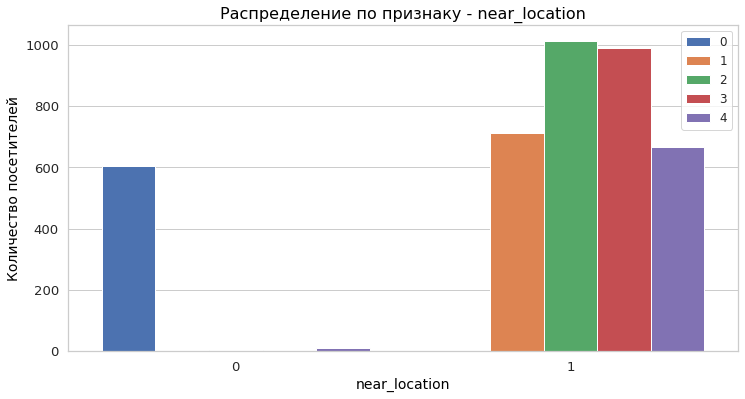

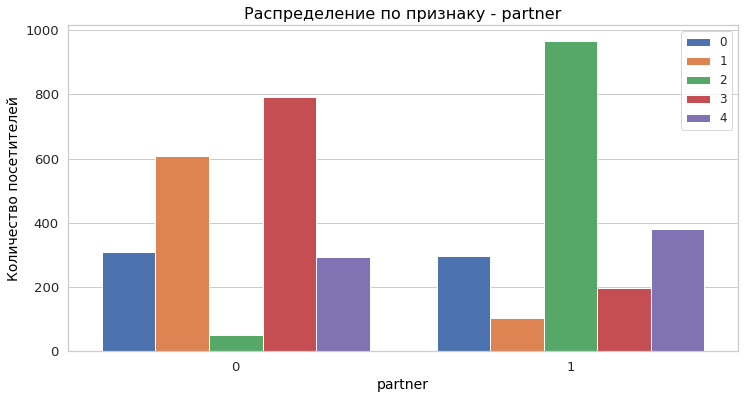

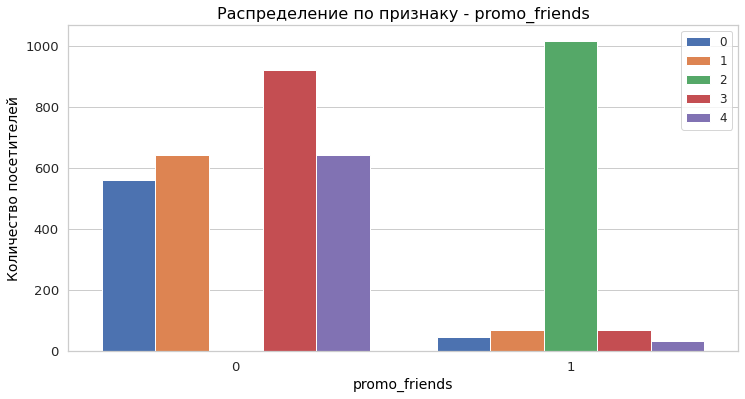

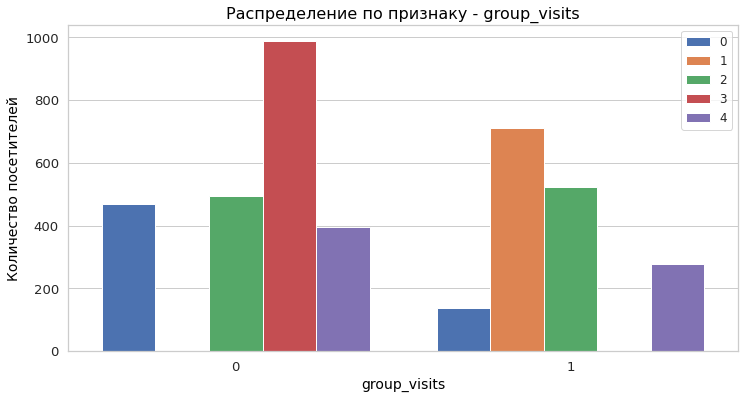

In [25]:
for column in ['near_location', 'partner', 'promo_friends', 'group_visits']:
    plt.figure(figsize=(12, 6))
    sns.set_style(style="whitegrid")
    ax = sns.countplot(data=dt_eda, x = dt_eda[column], hue='cluster', saturation=1)
    ax.set_title('Распределение по признаку - '  +column, fontsize = 16, color = 'black')
    plt.xlabel(column, fontsize = 14, color = 'black')
    plt.ylabel('Количество посетителей', fontsize = 14, color = 'black')
    ax.legend(loc='best', fontsize = 12)

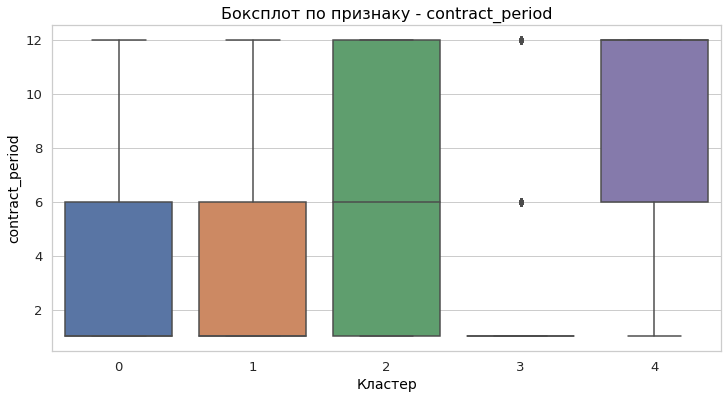

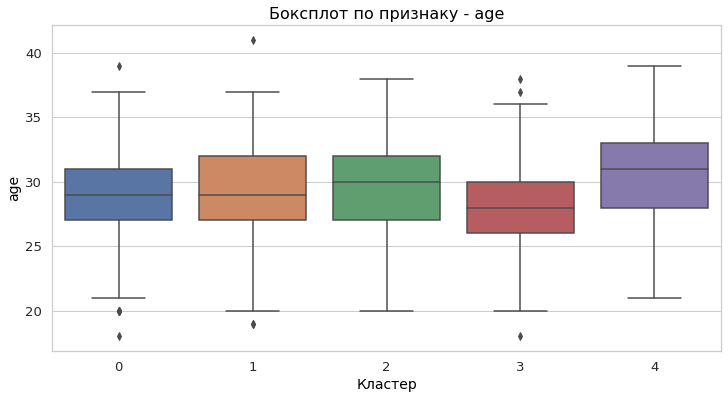

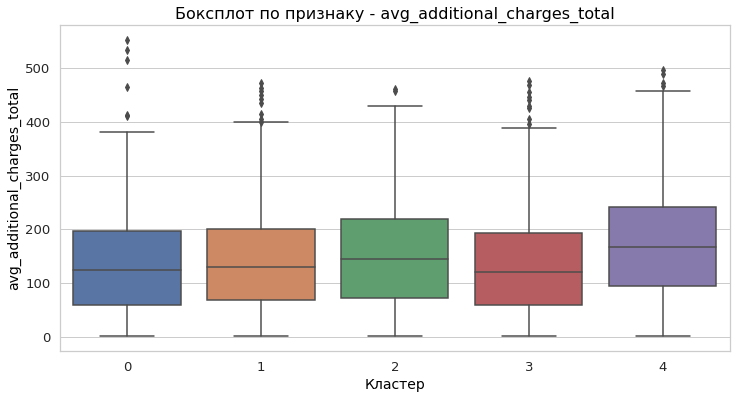

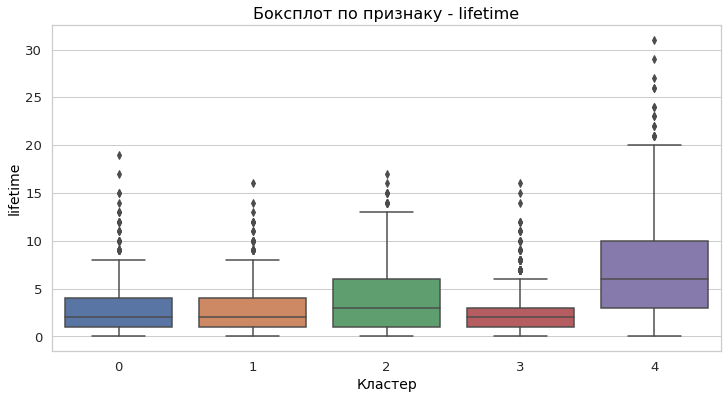

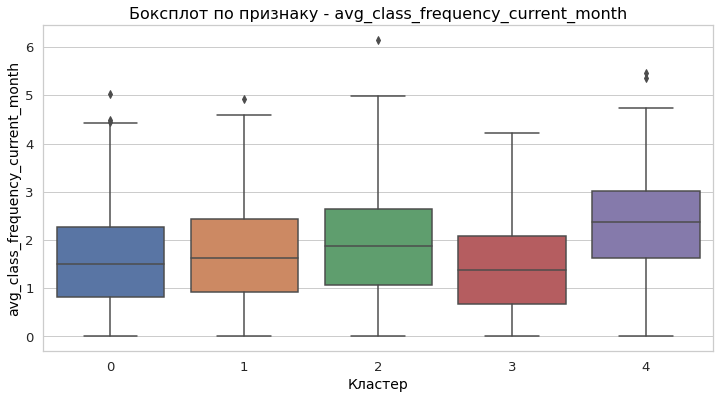

In [26]:
for column in ['contract_period', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']:
        plt.figure(figsize = (12,6))
        sns.boxplot(data=dt_eda, x = 'cluster', y = dt_eda[column])
        plt.title('Боксплот по признаку - ' +column, fontsize = 16, color = 'black')
        plt.ylabel(column, fontsize = 14, color = 'black')
        plt.xlabel('Кластер', fontsize = 14, color = 'black')

In [27]:
dt_eda.groupby('cluster')['churn'].mean().round(2).sort_values()

cluster
4    0.01
2    0.13
1    0.27
0    0.40
3    0.48
Name: churn, dtype: float64

Кластеры отличаются по доле оттока. 0 и 3 кластеры отличаются незначительно и в них клиенты склонны к оттоку. К надёжным можно отнести 4 и 2 кластеры. 

## Выводы

1. Средний портрет клиента Churn: 27 лет, ближняя локация, оформляет абонемент не более чем на 2 месяца, время с момента первого обращения в фитнес-центр - 1 месяц, не посещает групповые занятия, средняя частота посещений в неделю за предыдущий месяц - 1 раз в неделю.
2. Средний портрет клиента NoChurn: 30 лет, ближняя локация, оформляет абонемент на 6 месяцев, время с момента первого обращения в фитнес-центр - 5 месяцев, посещает групповые занятия, средняя частота посещений в неделю за предыдущий месяц - 2 раза в неделю.
3. Наибольшая корреляция с целевым показателем у следующих признаков: Lifetime(44%), Avg_class_frequency_current_month(41%) Age(40%), Contract_period(39%).
4. По трём показателям метрик accuracy, precision и recall модель RandomForestClassifier показал себя лучше, чем LogisticRegression. 
5. Модель кластеризации на основании алгоритма K-Means позволила более детально изучить клиентов разнесённых по 5 кластерам.
6. Средний портрет клиента кластера 4(Churn=0.01): 31 год, ближняя локация, оформляет абонемент на более чем на 8 месяцев, время с момента первого обращения в фитнес-центр - 7 месяцев, посещает групповые занятия, средняя частота посещений в неделю за предыдущий месяц - более 2 раз в неделю. 
7. Средний портрет клиента кластера 3(Churn=0.48): 28 лет, дальняя локация, оформляет абонемент на 2 месяца, время с момента первого обращения в фитнес-центр - 2 месяца, не посещает групповые занятия, средняя частота посещений в неделю за предыдущий месяц - менее 2 раз в неделю.
8. Отток клиентов в основном наблюдается среди молодых людей, взявших пробный абонемент на 1 - 2 месяца и по каким-то причинам не продлившие абонемент. Отсюда мои рекомендации.

## Рекомендации

Первое и единственное - необходимо разработать мероприятия по удержанию молодых клиентов и привлечению молодёжи:<br> 
1. Реклама в молодёжных соцсетях.
2. Раздача бесплатных абонементов мотивированным на занятия девушкам с обязательными условиями посещений.
3. Предлагать выгодные условия при приобретении долгосрочных абонеменов.